In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from tqdm import tqdm_notebook
import concurrent.futures
from multiprocessing import Pool
import copy,os,sys,psutil
from collections import Counter

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 禁用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# 参考
- [莫烦 RNN on Tensorflow](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-08-RNN2/#%E5%AE%9A%E4%B9%89-RNN-%E7%9A%84%E4%B8%BB%E4%BD%93%E7%BB%93%E6%9E%84)
- [莫烦 RNN on Pytorch](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-02-RNN-classification/)
- [Tensorflow 官方教程](https://www.tensorflow.org/tutorials/sequences/recurrent?hl=zh-cn)

# Morvan | Tensorflow
- [莫烦 RNN on Tensorflow](https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-08-RNN2/#%E5%AE%9A%E4%B9%89-RNN-%E7%9A%84%E4%B8%BB%E4%BD%93%E7%BB%93%E6%9E%84)

In [5]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.set_random_seed(1)   # set random seed

## Data Prepare

In [6]:
# 导入数据
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Model

### 超参数

In [7]:
# hyperparameters
lr = 0.001                  # learning rate
training_iters = 100000     # train step 上限
batch_size = 128            
n_inputs = 28               # MNIST data input (img shape: 28*28)
n_steps = 28                # time steps
n_hidden_units = 128        # neurons in hidden layer
n_classes = 10              # MNIST classes (0-9 digits)

### RNN建立计算图

In [8]:
# x y placeholder
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

# 对 weights biases 初始值的定义
weights = {
    # shape (28, 128)
    'in': tf.Variable(tf.random_normal([n_inputs, n_hidden_units])),
    # shape (128, 10)
    'out': tf.Variable(tf.random_normal([n_hidden_units, n_classes]))
}
biases = {
    # shape (128, )
    'in': tf.Variable(tf.constant(0.1, shape=[n_hidden_units, ])),
    # shape (10, )
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))
}

In [9]:
def RNN(X, weights, biases):
    # 原始的 X 是 3 维数据, 我们需要把它变成 2 维数据才能使用 weights 的矩阵乘法
    # X ==> (128 batches * 28 steps, 28 inputs)
    X = tf.reshape(X, [-1, n_inputs])

    # X_in = W*X + b
    X_in = tf.matmul(X, weights['in']) + biases['in']
    # X_in ==> (128 batches, 28 steps, 128 hidden) 换回3维
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])
    
    # 使用 basic LSTM Cell.
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden_units, forget_bias=1.0, state_is_tuple=True)
    init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32) # 初始化全零 state

    # 如果使用tf.nn.dynamic_rnn(cell, inputs), 我们要确定 inputs 的格式. tf.nn.dynamic_rnn 中的 time_major 参数会针对不同 inputs 格式有不同的值.
    # 如果 inputs 为 (batches, steps, inputs) ==> time_major=False;
    # 如果 inputs 为 (steps, batches, inputs) ==> time_major=True;
    outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, X_in, initial_state=init_state, time_major=False)
    
    results = tf.matmul(final_state[1], weights['out']) + biases['out']
    return results
pred = RNN(x, weights, biases)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


## Fit

In [14]:

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 0
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape([batch_size, n_steps, n_inputs])
        _ = sess.run([train_op], feed_dict={
            x: batch_xs,
            y: batch_ys,
        })
        if step % 20 == 0:
            print(sess.run(accuracy, feed_dict={x: batch_xs,y: batch_ys}))
        step += 1

0.296875
0.6796875
0.78125
0.7421875
0.828125
0.8671875
0.8984375
0.8828125
0.9375
0.921875
0.90625
0.9609375
0.8984375
0.9296875
0.9453125
0.96875
0.9765625
0.921875
0.9296875
0.9453125
0.9296875
0.953125
0.9453125
0.96875
1.0
0.9296875
0.9609375
0.984375
0.953125
0.9609375
0.984375
0.984375
0.9921875
0.96875


KeyboardInterrupt: 

# Morvan | Pytorch
- [莫烦 RNN on Pytorch](https://morvanzhou.github.io/tutorials/machine-learning/torch/4-02-RNN-classification/)

In [41]:
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter # torch 1.14 才会更新这个
import matplotlib.pyplot as plt
torch.manual_seed(1)    # reproducible

## Data Prepare

In [10]:
DOWNLOAD_MNIST = False  # 如果你已经下载好了mnist数据就写上 Fasle
root_path = "/home/zhoutong/data"

# Mnist 手写数字
# transform: 转换 PIL.Image or numpy.ndarray 成 torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
train_data = torchvision.datasets.MNIST(
    root=root_path,    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)
test_data = torchvision.datasets.MNIST(root=root_path, train=False)
train_data
test_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/zhoutong/data
    Split: Train

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/zhoutong/data
    Split: Test

torch.Size([60000, 28, 28])
torch.Size([60000])


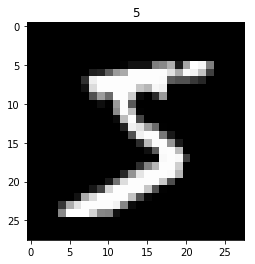

In [18]:
print(train_data.data.size())     # (60000, 28, 28)
print(train_data.targets.size())   # (60000)
_=plt.imshow(train_data.data[0].numpy(), cmap='gray')
_=plt.title('%i' % train_data.targets[0])
plt.show()

In [25]:
# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
test_x = test_data.data.type(torch.FloatTensor)[:2000]   # shape (2000, 28, 28) 
test_x = test_x/255. # normalize to range(0,1)
test_y = test_data.targets.numpy()[:2000]    # covert to numpy array

## Model

### 超参数

In [5]:
# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 64
TIME_STEP = 28      # rnn 时间步数 / 图片高度
INPUT_SIZE = 28     # rnn 每步输入值 / 图片每行像素
LR = 0.01           # learning rate


### RNN封装

In [28]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = torch.nn.LSTM(         # if use torch.nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1st dimension. e.g. (batch, time_step, input_size)
        )

        self.out = torch.nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out


## Fit

In [29]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [31]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = torch.nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [32]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):        # gives batch data
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.2883 | test accuracy: 0.10
Epoch:  0 | train loss: 0.8185 | test accuracy: 0.60
Epoch:  0 | train loss: 0.8619 | test accuracy: 0.76
Epoch:  0 | train loss: 0.6205 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2627 | test accuracy: 0.82
Epoch:  0 | train loss: 0.2186 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3307 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3876 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1891 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1416 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0623 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1515 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0547 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1727 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2030 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0713 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0867 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1881 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2081 | test accuracy

In [37]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print('pred number: ', pred_y)
print('true number: ', test_y[:10])

pred number:  [7 2 1 0 4 1 4 9 5 9]
true number:  [7 2 1 0 4 1 4 9 5 9]


# ~~Tensorflow Official~~
- [Tensorflow 官方教程](https://www.tensorflow.org/tutorials/sequences/recurrent?hl=zh-cn)

In [10]:
import collections

In [15]:
list(collections.OrderedDict.fromkeys([1,2,3,4,44,56,7,87,4,4,5,6,5]).keys())

[1, 2, 3, 4, 44, 56, 7, 87, 5, 6]

## Prepare

In [18]:
import reader
raw_data = reader.ptb_raw_data("/home/zhoutong/data/PTB/simple-examples/data")
train_data, valid_data, test_data, _ = raw_data

In [19]:
# 数据量太大，继续抽小样本
train_data, valid_data, test_data = train_data[:100], valid_data[:20], test_data[:20]
len(train_data)

In [21]:
class PTBInput(object):
    """The input data."""

    def __init__(self, config, data, name=None):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        self.epoch_size = ((len(data) // batch_size) - 1) // num_steps
        self.input_data, self.targets = reader.ptb_producer(
            data, batch_size, num_steps, name=name)

## Config

In [22]:
BASIC = "basic"
CUDNN = "cudnn"
BLOCK = "block"
class TestConfig(object):
    """Tiny config, for testing."""
    init_scale = 0.1
    learning_rate = 1.0
    max_grad_norm = 1
    num_layers = 1
    num_steps = 2
    hidden_size = 2
    max_epoch = 1
    max_max_epoch = 1
    keep_prob = 1.0
    lr_decay = 0.5
    batch_size = 20
    vocab_size = 10000 # 词的id数最大到9999
    rnn_mode = BLOCK
    
config = TestConfig() # 训练时初始化用的config
eval_config = TestConfig() # 验证时用的config
eval_config.batch_size = 1
eval_config.num_steps = 1

In [ ]:
train_input = PTBInput(config=config, data=train_data, name="TrainInput")
train_input.batch_size
train_input.num_steps
train_input.input_data.graph
tf.get_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res = sess.run(train_input.input_data)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


20

2

In [ ]:
res

In [63]:
with tf.get_default_graph().as_default():
    initializer = tf.random_uniform_initializer(-config.init_scale,
                                                config.init_scale)

    with tf.name_scope("Train"):
        train_input = PTBInput(config=config, data=train_data, name="TrainInput")

        #         with tf.variable_scope("Model", reuse=None, initializer=initializer):
        #             m = PTBModel(is_training=True, config=config, input_=train_input)
        #         tf.summary.scalar("Training Loss", m.cost)
        #         tf.summary.scalar("Learning Rate", m.lr)

        # 封装的模型PTBModel的初始化参数
        _is_training = True
        _input = train_input
        config = config
        # 数据的参数
        batch_size = _input.batch_size
        num_steps = _input.num_steps
        # 模型结构
        _rnn_params = None
        _cell = None
        # 超参数
        size = config.hidden_size
        vocab_size = config.vocab_size

        # 构建embedding
        with tf.device("/cpu:0"):
            embedding = tf.get_variable("embedding", [vocab_size, size], dtype=tf.float32)
            inputs = tf.nn.embedding_lookup(embedding, _input.input_data)
        # 若在训练过程中，使用dropout
        if _is_training and config.keep_prob < 1:
            inputs = tf.nn.dropout(inputs, config.keep_prob)
        # 构建rnn计算图
        def make_cell():
            cell = tf.contrib.rnn.LSTMBlockCell(config.hidden_size, forget_bias=0.0)
            if is_training and config.keep_prob < 1:
                cell = tf.contrib.rnn.DropoutWrapper(
                    cell, output_keep_prob=config.keep_prob)
            return cell
        # MultiRNNCell | 多个LSTM内部结构前一个的输出是后一个的输入，inp -> lstm1 -> lstm2 -> lstm3 -> out
        cell = tf.contrib.rnn.MultiRNNCell([make_cell() for _ in range(config.num_layers)], state_is_tuple=True)
        # state状态 | 一开始MultiRNNCell都做全零初始化 zero_state
        _initial_state = cell.zero_state(config.batch_size, tf.float32)
        state = _initial_state
        # outputs输出
        outputs = []
        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0: 
                    tf.get_variable_scope().reuse_variables()
                (cell_output, state) = cell(inputs[:, time_step, :], state)
                outputs.append(cell_output)
        output = tf.reshape(tf.concat(outputs, 1), [-1, config.hidden_size])
        
#         output, state = self._build_rnn_graph(inputs, config, is_training)
        
    with tf.name_scope("Valid"):
        pass

    with tf.name_scope("Test"):
        pass

NameError: name 'is_training' is not defined

# Tensorflow 某个博客
- [TensorFlow入门（五） 多层LSTM通俗易懂版](https://blog.csdn.net/Jerr__y/article/details/61195257)
多层结构的示意图：
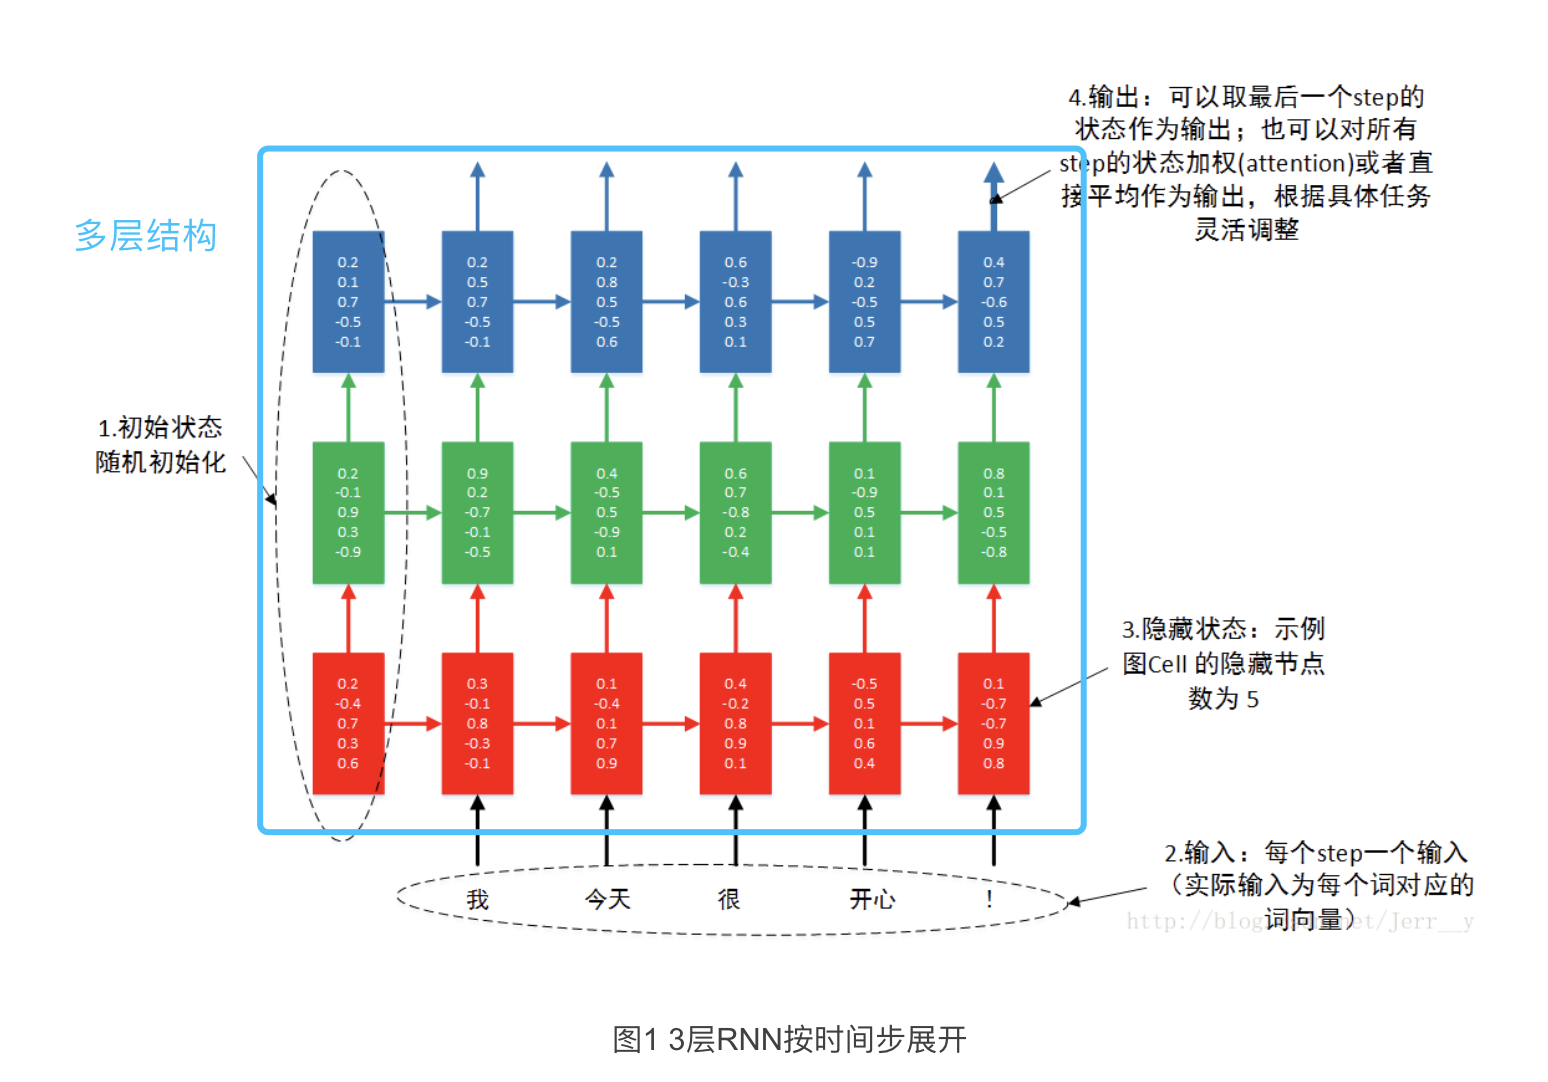

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

## 超参数

In [5]:
lr = 1e-3
input_size = 28 # 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
timestep_size = 28 # 时序持续长度为28，即每做一次预测，需要先输入28行
hidden_size = 256 # 每个隐含层的节点数
layer_num = 2 # LSTM layer 的层数
class_num = 10 # 最后输出分类类别数量，如果是回归预测的话应该是 1

## Prepare

In [6]:
# 首先导入数据，看一下数据的形式
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print(mnist.train.images.shape)
# batch数据（一个iterator或者说generator）
batch = mnist.train.next_batch(128)
batch

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 784)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

## Model

### Placeholder

In [7]:
X_inp = tf.placeholder(tf.float32, [None, 784],name="X_inp")
y = tf.placeholder(tf.float32, [None, class_num],name="y")
batch_size = tf.placeholder(tf.int32,[],name="batch_size")
keep_prob = tf.placeholder(tf.float32,[],name="keep_prob")
X = tf.reshape(X_inp,[-1,28,28],name="X")

### 构造多层LSTM及初始化状态

In [8]:
def make_cell(hidden_size:int,is_training:bool=True, keep_prob:float=0.8):
    cell = tf.contrib.rnn.LSTMBlockCell(hidden_size, forget_bias=0.0)
    if is_training and keep_prob < 1:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

#mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size)] * layer_num, state_is_tuple=True)
# 会导致WARNING:tensorflow:At least two cells provided to MultiRNNCell are the same object and will share weights.
mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size) for _ in range(layer_num)], state_is_tuple=True)
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

### mlstm_cell的计算图 | 复用（共享）参数

#### ~~方案一 | dynamic_rnn~~
time_major的含义
- time_major参数针对不同的inputs格式选取不同的值
- `inputs` 为 `(batches, steps, inputs)` ==> `time_major=False`
 - outputs.shape = [batch_size, timestep_size, hidden_size] 
 - 可以取 h_state = outputs[:, -1, :] 或者 h_state = state[-1][1] 作为最后输出
   - 即序列（timestep）的最后一个输出
   - 维度是 [batch_size, hidden_size]
- `inputs` 为 `(steps, batches, inputs)` ==> `time_major=True`

"Morvan"的例子中给出的解释
>如果使用tf.nn.dynamic_rnn(cell, inputs), 我们要确定 inputs 的格式. tf.nn.dynamic_rnn 中的 time_major 参数会针对不同 inputs 格式有不同的值.
>- 如果 inputs 为 (batches, steps, inputs) ==> time_major=False;
>- 如果 inputs 为 (steps, batches, inputs) ==> time_major=True;

In [9]:
outputs, final_state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)

#### 方案二 | 展开dynamic_rnn自行实现

In [10]:
# **步骤6：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
# outputs, state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)
# h_state = outputs[:, -1, :]  # 或者 h_state = state[-1][1]

# *************** 为了更好的理解 LSTM 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数（见最后附），我们可以用它来展开实现LSTM按时间步迭代。
# **步骤6：方法二，按时间步展开计算
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        if timestep > 0:
            tf.get_variable_scope().reuse_variables()
        # 这里的state保存了每一层 LSTM 的状态
        (cell_output, state) = mlstm_cell(X[:, timestep, :], state)
        outputs.append(cell_output)
h_state = outputs[-1]
tf.summary.histogram("h_state",h_state)

<tf.Tensor 'h_state:0' shape=() dtype=string>

### softmax | (256 -> 10)
outputs里的是256维的输出，用softmax处理成10维的数字分类

In [11]:
# 上面 LSTM 部分的输出会是一个 [hidden_size] 的tensor，我们要分类的话，还需要接一个 softmax 层
# 首先定义 softmax 的连接权重矩阵和偏置
# out_W = tf.placeholder(tf.float32, [hidden_size, class_num], name='out_Weights')
# out_bias = tf.placeholder(tf.float32, [class_num], name='out_bias')
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)
tf.summary.histogram("softmax_W",W)
tf.summary.histogram("softmax_bias",bias)

<tf.Tensor 'softmax_W:0' shape=() dtype=string>

<tf.Tensor 'softmax_bias:0' shape=() dtype=string>

## loss-func & optimizer

In [14]:
# loss
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
# optimizer
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
# eval
correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) # 映射 bool -> float即T/F到1.0/0.0；取均值则为100个样本中有90个预测正确
tf.summary.scalar("acc",accuracy)

<tf.Tensor 'acc:0' shape=() dtype=string>

## Run fit

In [16]:
merged_opt = tf.summary.merge_all()
train_writer = tf.summary.FileWriter("./TensorBoards/RNN/logs_20190618/train",tf.get_default_graph())
test_writer = tf.summary.FileWriter("./TensorBoards/RNN/logs_20190618/test",tf.get_default_graph())
# train_writer.add_graph(tf.get_default_graph())
# test_writer.add_graph(tf.get_default_graph())
train_batch_size = 128
feed_dict_test = {X_inp: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size:mnist.test.images.shape[0]}
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print("init finished.")
for i in range(2000):
    (train_data,train_label) = mnist.train.next_batch(train_batch_size)
    feed_dict_train = {X_inp:train_data, y: train_label, keep_prob: 0.5, batch_size:train_batch_size}
    if (i+1)%200 == 0: # once each 200
        # acc of train
        feed_dict_train_acc = feed_dict_train.copy()
        feed_dict_train_acc.update({keep_prob: 1.0})
        train_summary,train_acc = sess.run([merged_opt,accuracy], feed_dict=feed_dict_train_acc)
        train_writer.add_summary(train_summary,i)
        test_summary,test_acc = sess.run([merged_opt,accuracy], feed_dict=feed_dict_test)
        test_writer.add_summary(test_summary,i)
        print (f"epoch: {mnist.train.epochs_completed}, step: {(i+1)}, train acc: {train_acc}, test_acc: {test_acc} ")
    summary,_ = sess.run([merged_opt,train_op], feed_dict=feed_dict_train)
    train_writer.add_summary(summary,i)
print (f"test accuracy {sess.run(accuracy, feed_dict=feed_dict_test)}")

init finished.
epoch: 5, step: 200, train acc: 0.8671875, test_acc: 0.9072999954223633 
epoch: 6, step: 400, train acc: 0.9609375, test_acc: 0.9520999789237976 
epoch: 6, step: 600, train acc: 0.96875, test_acc: 0.96670001745224 
epoch: 6, step: 800, train acc: 0.984375, test_acc: 0.9750000238418579 
epoch: 7, step: 1000, train acc: 0.96875, test_acc: 0.9789000153541565 
epoch: 7, step: 1200, train acc: 0.9921875, test_acc: 0.9797999858856201 
epoch: 8, step: 1400, train acc: 0.9921875, test_acc: 0.9815000295639038 
epoch: 8, step: 1600, train acc: 0.984375, test_acc: 0.982200026512146 
epoch: 9, step: 1800, train acc: 0.9921875, test_acc: 0.9850999712944031 
epoch: 9, step: 2000, train acc: 0.9765625, test_acc: 0.9847000241279602 
test accuracy 0.984000027179718


## 可视化验证每行输入会如何

In [18]:
import matplotlib.pyplot as plt
print(mnist.train.labels[4])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


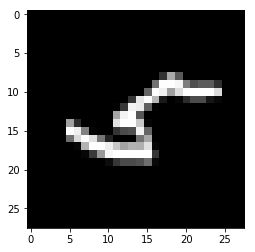

In [19]:
X3 = mnist.train.images[4]
img3 = X3.reshape([28, 28])
plt.imshow(img3, cmap='gray')
plt.show()

In [20]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            X_inp: X3, y: y_batch, keep_prob: 1.0, batch_size: 1}))
print(X3_outputs.shape)
X3_outputs.shape = [28, hidden_size]
print(X3_outputs.shape)

NameError: name '_X' is not defined

In [ ]:
h_W = sess.run(W, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = sess.run(bias, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias.shape = [-1, 10]

bar_index = range(class_num)
for i in xrange(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.2 , align='center')
    plt.axis('off')
plt.show()

# 验证、解释一些function

## 变量说明
| var | shape | example | info |
| :---- | :---- | :--- | :---- |
| X | (batch_size, timestep_size, input_size) | (128, 28, 28) |
| X[ :, timestep, :] | (batch_size, input_size) | (128,28) | 128个数据的第timestep行（一行28维）<br> $timestep \in [0, timestep\_size]$ |
| init_state | layer_num*[(batch_size, hidden_size)] | 2*[(128, 256)] | 2维数组，内嵌`128*256`的tensor |
| outputs | timestep_size*[(batch_size,hidden_size)] | 28*[(128, 256)] | 28维数组，内嵌`128*256`的tensor | 
| h_state | (batch_size, hidden_size) | (128, 256) | 是outputs的最后一个元素 |
| W | (hidden_size, class_num) | (256, 10) | softmax的权重 |
| bias | (class_num) | (10) | softmax的bias |
| y_pre | (batch_size, class_num) | (128, 10) |

##  一些报错的原因及解决
### MultiRNNCell
> WARNING:tensorflow:At least two cells provided to MultiRNNCell are the same object and will share weights.

CODE: `mlstm_cell = tf.contrib.rnn.MultiRNNCell([make_cell(hidden_size)] * layer_num, state_is_tuple=True)`

因为使用了 `[cell]*3` 来构造多层LSTM，这个方法实际上这3层LSTM都用的是同一个对象`cell`，所以权重也都是相同的

正确写法是`[cell for _ in range(3)]`

### Case1: dynamic_rnn (with a fixed batch_size=128)
> ValueError: Input tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/LSTMBlockCellZeroState/zeros:0' enters the loop with shape (128, 256), but has shape (?, 256) after one iteration. To allow the shape to vary across iterations, use the `shape_invariants` argument of tf.while_loop to specify a less-specific shape.

CODE: `outputs, final_state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)`

### Case2: when do predict (with a fixed batch_size=128)
>InvalidArgumentError: cs_prev.dims(0) != batch_size: 128 vs. 10000

CODE: `sess.run(accuracy, feed_dict=feed_dict_test)`

以上两个Case都是因为`batch_size`不能是固定的，改用一个`placeholder`传入它
- 参考[github的一个issue](https://github.com/tensorflow/tensorflow/issues/15737)

### mnist.train.next_batch (with batch_size as placeholder)
> TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed.

CODE: `(train_data,train_label) = mnist.train.next_batch(batch_size)`

原因是tf加载mnist数据的内部python使用了形如 `start + batch_size > self.num` 的形式

暂时解决：直接将获取`next_batch`的`batch_size`设定为固定值，注意在`feed_dict`中也要给`batch_size`填这个值才行，如下
```
train_batch_size = 128
(train_data,train_label) = mnist.train.next_batch(train_batch_size)
feed_dict_train = {_X:train_data, y: train_label, keep_prob: 1.0, batch_size:train_batch_size}
```

## Tensorflow API解释

### tf.stack
- stack要求两个tensor维度必须是相同的，本来是 $[D_1,D_2,..D_n]$ 的共n个维度的俩tensor，stack后变成n+1个维度，多+1的那个维度为`2`，具体这个+1的维度`2`放在哪就由`axis=`决定，`axis=0`那这个`2`就放在索引0上

shape为(3,4,5)的两个tensor在不同axis上做stack
- axis=0: (**2**,3,4,5)
- axis=1: (3,**2**,4,5)
- axis=2: (3,4,**2**,5)
- axis=3: (3,4,5,**2**)

stack三个维度相同的tensor那就是把`3`添加在`axis`指定的索引位置上

In [49]:
a = np.random.random([3,4,5])
b = np.random.random([3,4,5])
e = np.random.random([3,4,5])
c = tf.stack([a,b,e], axis=3)
a.shape
b.shape
c.shape

(3, 4, 5)

(3, 4, 5)

TensorShape([Dimension(3), Dimension(4), Dimension(5), Dimension(3)])

### tf.unstack
按`axis`指定的维度拆开，该维度取值是多少就拆成多少个tensor

shape为(3,4,5,2)的一个tensor在不同axis上做unstack
- axis=0: [(4,5,2)]*3
- axis=1: [(3,5,2)]*4
- axis=2: [(3,4,2)]*5
- axis=3: [(3,4,5)]*2

In [57]:
m = np.random.random([3,4,5,2])
m.shape
tf.unstack(m)
tf.unstack(m,axis=0)
tf.unstack(m,axis=1)
tf.unstack(m,axis=2)
tf.unstack(m,axis=3)

# ?tf.unstack

(3, 4, 5, 2)

[<tf.Tensor 'unstack_10:0' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_10:1' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_10:2' shape=(4, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_11:0' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_11:1' shape=(4, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_11:2' shape=(4, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_12:0' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:1' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:2' shape=(3, 5, 2) dtype=float64>,
 <tf.Tensor 'unstack_12:3' shape=(3, 5, 2) dtype=float64>]

[<tf.Tensor 'unstack_13:0' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:1' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:2' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:3' shape=(3, 4, 2) dtype=float64>,
 <tf.Tensor 'unstack_13:4' shape=(3, 4, 2) dtype=float64>]

[<tf.Tensor 'unstack_14:0' shape=(3, 4, 5) dtype=float64>,
 <tf.Tensor 'unstack_14:1' shape=(3, 4, 5) dtype=float64>]

### tf.reduce_mean
tf.reduce_mean, reduce_sum, reduce_max就是计算某一个维度上的均值、加和、最值
>tf.reduce_mean(input_tensor, axis=None, keepdims=None, name=None, reduction_indices=None, keep_dims=None)
- axis：
    - axis=None, 求全部元素的平均值；
    - axis=0, 列平均值；
    - axis=1，行平均值。 
- keep_dims：若值为True，可多行输出平均值。 
- name：自定义操作名。 
- ~~reduction_indices：axis的旧名，已停用。~~

In [56]:
np.random.seed(2019)
a = np.random.randint(0,10,size=[2,3])
# a = tf.Variable(a)
a
a.shape
with tf.Session() as sess:
    sess.run(tf.reduce_sum(a,axis=None))
    sess.run(tf.reduce_mean(a,axis=None))
    sess.run(tf.reduce_mean(a,axis=0))

array([[8, 2, 5],
       [8, 6, 8]])

(2, 3)

37

6

array([8, 4, 6])

### tf.transpose
> tf.transpose(a, perm=None, name='transpose', conjugate=False)
- a 需要转置的tensor
- perm （permute）转置的形式
    - `None` 表示把shape倒转过来，如[3,4]变成[4,3]，[1,2,3,4]变成[4,3,2,1]
    - `list[int]类型` 里面的int表示原始维度的索引按list里的顺序来排列
        - 如`[0,3,2,1]`表示原始的维度`3`放到第二个,`1`放到第四个（二、四维互换了）
        - 如`[1,3,2,0]`表示转置后的，按数字作为索引把原始的维度按当前list里的顺序重新排列

In [23]:
a = np.random.random([3,4,5,6])
a.shape
tf.transpose(a)
tf.transpose(a,[2,1,0,3])

(3, 4, 5, 6)

<tf.Tensor 'transpose_8:0' shape=(6, 5, 4, 3) dtype=float64>

<tf.Tensor 'transpose_9:0' shape=(5, 4, 3, 6) dtype=float64>

### tf.truncated_normal
按指定均值、标准差生成正态分布的数据，并且做两倍标准差截断
> tf.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None) :
- shape表示生成张量的维度
- mean是均值 | 默认为0
- stddev是标准差。 | 默认为1.0
- seed随机数种子
>
>这个函数产生正太分布，均值和标准差自己设定。这是一个截断的产生正太分布的函数，就是说产生正太分布的值如果与均值的差值大于两倍的标准差，那就重新生成。和一般的正太分布的产生随机数据比起来，这个函数产生的随机数与均值的差距不会超过两倍的标准差，但是一般的别的函数是可能的。

tf里的随机数种子，可以设置到图级别也可以设置为op级别
- 图级别：
```
# at some graph
tf.set_random_seed(2019)
tf.truncated_normal([3,4],stddev=0.1)
```
- op级别：
```
tf.truncated_normal([3,4],stddev=0.1,seed=2019)
```

类似的随机函数还有 `tf.random_uniform([3,4], -1, 1)` 生成-1到1的均匀分布的随机数
>tf.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)

In [36]:
# truncated_normal 按正态分布生成数据，并且做标准差截断
with tf.Session() as sess:
    random_op = tf.truncated_normal([3,4],stddev=0.1,seed=2019)
    # random_op在一段程序里跑了三次，seed只控制程序每次相同位置生成时结果是一样的，而这三次则都不一样
    sess.run(random_op)
    sess.run(tf.cast(random_op,tf.int32))
    sess.run(tf.to_float(random_op,tf.int32))

array([[-0.01135067,  0.05639387, -0.04778707,  0.04571497],
       [ 0.1153388 ,  0.07203745,  0.15631334, -0.16913354],
       [ 0.124575  , -0.04655875,  0.0504917 ,  0.06605241]],
      dtype=float32)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

array([[ 0.04278614,  0.16716555, -0.01701541, -0.00202826],
       [ 0.11125483,  0.07280847, -0.07696502, -0.1261591 ],
       [-0.01496598, -0.01382563, -0.05033821, -0.02851957]],
      dtype=float32)

### tf.while_loop

In [17]:
i  = 0
n =10 

def cond(i, n):
    return i < n

def body(i, n):
    i = i + 1
    return i, n
i, n = tf.while_loop(cond, body, [i, n])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([i,n])

[10, 10]

## reuse_variables | 为什么RNN scope的循环内每次（timestep>0后）都要设置一下reuse_variables

In [39]:
# 为什么RNN scope的循环内每次（timestep>0后）都要设置一下reuse_variables
# 从结果来看似乎没有必要
timestep_size_test = 8
print(f"timestep_size_test: {timestep_size_test}")
print(">>>into loop")
with tf.variable_scope('RNN_test'):
    res0 = tf.get_variable_scope()
    for timestep in range(timestep_size_test):
        print(f"  timestep: {timestep}, 当前状态scope是否可reuse: {tf.get_variable_scope().reuse}")
        if timestep > 0:
            print(f"    trigger reuse.")
            tf.get_variable_scope().reuse_variables()
            pass
        print(f"  is reuse-able: {tf.get_variable_scope().reuse}")
        pass
    pass

print(">>>into loop")
with tf.variable_scope('RNN_test'):
    res0 = tf.get_variable_scope()
    for timestep in range(timestep_size_test):
        print(f"  timestep: {timestep}, 当前状态scope是否可reuse: {tf.get_variable_scope().reuse}")
        if timestep == 1:
            print(f"    trigger reuse.")
            tf.get_variable_scope().reuse_variables()
            pass
        print(f"is reuse-able: {tf.get_variable_scope().reuse}")
        pass
    pass

        

timestep_size_test: 8
>>>into loop
  timestep: 0, 当前状态scope是否可reuse: False
  is reuse-able: False
  timestep: 1, 当前状态scope是否可reuse: False
    trigger reuse.
  is reuse-able: True
  timestep: 2, 当前状态scope是否可reuse: True
    trigger reuse.
  is reuse-able: True
  timestep: 3, 当前状态scope是否可reuse: True
    trigger reuse.
  is reuse-able: True
  timestep: 4, 当前状态scope是否可reuse: True
    trigger reuse.
  is reuse-able: True
  timestep: 5, 当前状态scope是否可reuse: True
    trigger reuse.
  is reuse-able: True
  timestep: 6, 当前状态scope是否可reuse: True
    trigger reuse.
  is reuse-able: True
  timestep: 7, 当前状态scope是否可reuse: True
    trigger reuse.
  is reuse-able: True
>>>into loop
  timestep: 0, 当前状态scope是否可reuse: False
is reuse-able: False
  timestep: 1, 当前状态scope是否可reuse: False
    trigger reuse.
is reuse-able: True
  timestep: 2, 当前状态scope是否可reuse: True
is reuse-able: True
  timestep: 3, 当前状态scope是否可reuse: True
is reuse-able: True
  timestep: 4, 当前状态scope是否可reuse: True
is reuse-able: True
  timestep:

## mnist.train.next_batch

In [24]:
# next_batch 的用法
batch = mnist.train.next_batch(batch_size)
batch[1][:2].shape # label of 2 samples
batch[0][:2].shape # data of 2 samples

(data,label) = mnist.train.next_batch(batch_size)
len(data)
len(label)

mnist.train.next_batch(10)[0].shape
mnist.train.next_batch(10)[1].shape

print("train_data&train_label.shape")
train_data.shape
train_label.shape
print("mnist.text.images&labels.shape")
mnist.test.images.shape
mnist.test.labels.shape

(2, 10)

(2, 784)

128

128

(10, 784)

(10, 10)

train_data&train_label.shape


(128, 784)

(128, 10)

mnist.text.images&labels.shape


(10000, 784)

(10000, 10)

## X的shape

In [19]:
# X 的shape
with tf.Session() as sess:
    res = sess.run(X,feed_dict={_X:batch[0],y:batch[1]})
    res.shape
    res[:,0,:]

(128, 28, 28)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## state的shape
`lstm`的`state`可以被分为`(c_state, h_state)`各是`[batch_size,hidden_size]`维度

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res_state = sess.run(state,feed_dict={_X:batch[0],y:batch[1]})
    len(res_state)
    res_state[0].c.shape
    res_state[0].h.shape
    res_state[1].c
    res_state[1].h

2

(128, 256)

(128, 256)

array([[-4.71040560e-03, -6.89876080e-03,  4.54083923e-03, ...,
        -2.79504829e-03, -4.92951542e-04, -1.43623166e-03],
       [-1.42937212e-03, -1.17261913e-02,  1.27614951e-02, ...,
        -8.78702290e-03,  2.40396429e-03, -6.06853236e-03],
       [-4.78304370e-04, -3.41708655e-03,  4.37778141e-03, ...,
         3.45885940e-03,  1.85991393e-03,  4.79990937e-04],
       ...,
       [-6.82872487e-03, -7.66355451e-03,  1.70704592e-02, ...,
         9.80795547e-03,  1.25894165e-02,  1.31201360e-03],
       [-9.68033128e-05, -1.04226302e-02,  2.04816945e-02, ...,
        -8.01454950e-03, -1.83850096e-03, -1.05275540e-02],
       [-3.19436239e-03, -4.29114932e-03,  9.22775734e-03, ...,
        -3.15551530e-03,  4.33840975e-03,  3.24420747e-03]], dtype=float32)

array([[-2.3557211e-03, -3.4485445e-03,  2.2768609e-03, ...,
        -1.4005448e-03, -2.4624754e-04, -7.1750052e-04],
       [-7.1285246e-04, -5.8508469e-03,  6.3986215e-03, ...,
        -4.4068103e-03,  1.1969535e-03, -3.0371223e-03],
       [-2.3913455e-04, -1.7073074e-03,  2.1904206e-03, ...,
         1.7292892e-03,  9.2880818e-04,  2.4013409e-04],
       ...,
       [-3.4090679e-03, -3.8135003e-03,  8.5490681e-03, ...,
         4.9129124e-03,  6.2715239e-03,  6.5487524e-04],
       [-4.8320162e-05, -5.2060238e-03,  1.0295696e-02, ...,
        -4.0265545e-03, -9.1728597e-04, -5.2783261e-03],
       [-1.5918264e-03, -2.1425504e-03,  4.6117362e-03, ...,
        -1.5783183e-03,  2.1629606e-03,  1.6258138e-03]], dtype=float32)

## X[:, timestep, :] 是什么效果

In [48]:
# 验证 [:, timestep, :] 是什么效果 | batch_size为4，time_step_size为2，feature_size(emb_size)为2，每次四个样本都先输入time_step0的所有feature再输入time_step1的所有feature 。。。
test = np.random.rand(4,2,2) # 四张2*2的图
test.shape
test
test[:,0,:]
test[:,1,:]

(4, 2, 2)

array([[[0.27241369, 0.73211864],
        [0.95745742, 0.89549498]],

       [[0.8416712 , 0.99420095],
        [0.87493714, 0.74828419]],

       [[0.10730276, 0.64778521],
        [0.46521779, 0.56854996]],

       [[0.43857643, 0.06174464],
        [0.55166392, 0.27123771]]])

array([[0.27241369, 0.73211864],
       [0.8416712 , 0.99420095],
       [0.10730276, 0.64778521],
       [0.43857643, 0.06174464]])

array([[0.95745742, 0.89549498],
       [0.87493714, 0.74828419],
       [0.46521779, 0.56854996],
       [0.55166392, 0.27123771]])